In [2]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score


# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from plot3D import *

np.random.seed(47)
%matplotlib inline

In [3]:
def array_to_color(array, cmap="Oranges"):
    s_m = plt.cm.ScalarMappable(cmap=cmap)
    return s_m.to_rgba(array)[:,:-1]


def rgb_data_transform(data):
    data_t = []
    for i in range(data.shape[0]):
        data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
    return np.asarray(data_t, dtype=np.float32)

In [4]:
with h5py.File("./train_point_clouds.h5", "r") as hf:    
    a = hf["0"]
    b = a['img'][:]
    s = a['points'][:]

Text(0.5, 1.0, 'The figure 5 in 2d')

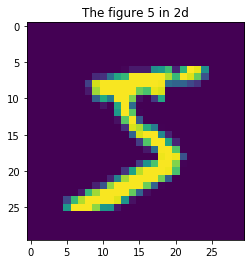

In [5]:
plt.imshow(b)
plt.title('The figure 5 in 2d')

Text(0.5, 0.92, 'The figure 5 in 3d Cloud point')

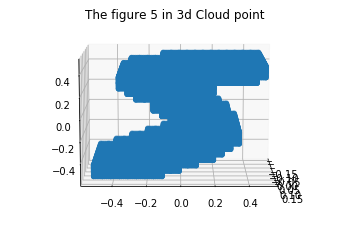

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s[:,0], s[:,1], zs=s[:,2])
ax.view_init(10, 0)
plt.title('The figure 5 in 3d Cloud point')


In [7]:
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

#     # Convert target vectors to categorical targets
#     targets_train = to_categorical(targets_train).astype(np.integer)
#     targets_test = to_categorical(targets_test).astype(np.integer)

In [8]:
X_train.shape, X_test.shape

((10000, 16, 16, 16, 3), (2000, 16, 16, 16, 3))

In [9]:
X_train = X_train.reshape(10000,3,16,16,16)
X_test = X_test.reshape(2000,3,16,16,16)

In [10]:
targets_train.shape, targets_test.shape

((10000,), (2000,))

In [11]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(targets_train).long()

In [12]:
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(targets_test).long()

In [13]:
# batch_size, epoch and iteration
batch_size = 100


# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x,train_y)
test = torch.utils.data.TensorDataset(test_x,test_y)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [20]:
num_classes = 10

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(2**3*64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#Definition of hyperparameters
n_iters = 4500
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)

# Create CNN
model = CNNModel()
#model.cuda()
print(model)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.15, inplace=False)
)


In [21]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,3,16,16,16))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,3,16,16,16))
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8045936822891235  Accuracy: 33.099998474121094 %
Iteration: 1000  Loss: 1.5683561563491821  Accuracy: 39.900001525878906 %
Iteration: 1500  Loss: 1.4095323085784912  Accuracy: 45.900001525878906 %
Iteration: 2000  Loss: 1.327325463294983  Accuracy: 48.45000076293945 %
Iteration: 2500  Loss: 1.2187552452087402  Accuracy: 51.5 %
Iteration: 3000  Loss: 1.1305687427520752  Accuracy: 53.25 %
Iteration: 3500  Loss: 1.0787715911865234  Accuracy: 54.20000076293945 %
Iteration: 4000  Loss: 1.040664553642273  Accuracy: 55.20000076293945 %
Iteration: 4500  Loss: 0.9507399201393127  Accuracy: 55.20000076293945 %


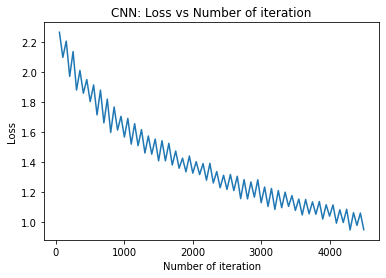

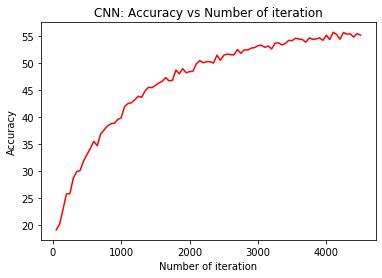

In [22]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()